# Minería de Datos: Trabajo Final:

### Importación de las librerías necesarias:

In [18]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import neighbors

### Lectura de datos:

Leemos los datos:

In [2]:
data_path = 'data/test.csv'
data = pd.read_csv(data_path, index_col=0, usecols=[1, 2, 3, 4, 7, 8, 9, 10, 24])
data.head()

,Gender,Customer Type,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,satisfaction
id,,,,,,,,
19556,Female,Loyal Customer,52,160,5,4,3,satisfied
90035,Female,Loyal Customer,36,2863,1,1,3,satisfied
12360,Male,disloyal Customer,20,192,2,0,2,neutral or dissatisfied
77959,Male,Loyal Customer,44,3377,0,0,0,satisfied
36875,Female,Loyal Customer,49,1182,2,3,4,satisfied


Separamos los datos en X e y:

In [3]:
variablesEntrada = ['Gender', 'Customer Type', 'Age', 'Flight Distance',
       'Inflight wifi service', 'Departure/Arrival time convenient',
       'Ease of Online booking']
variableSalida = ['satisfaction']

X = data[variablesEntrada].copy()
y = data[variableSalida].copy()

Convertimos las categorías a números con codificación ordinal:

In [4]:
y.loc[y["satisfaction"] == "satisfied", "satisfaction"] = 1
y.loc[y["satisfaction"] == "neutral or dissatisfied", "satisfaction"] = 0

### Análisis de los datos:

Analizamos la distribución de las clases de salida:

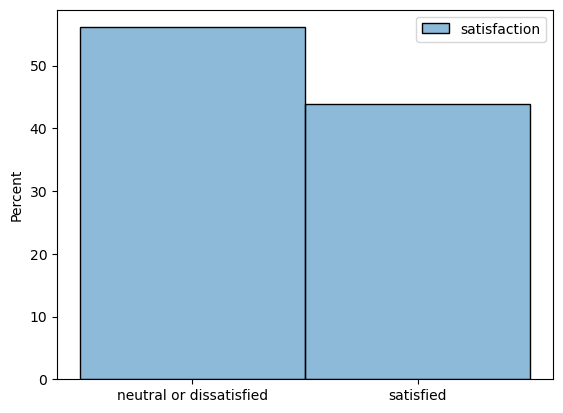

In [5]:
clase_0 = "neutral or dissatisfied"
clase_1 = "satisfied"

sns.histplot(data=y, bins=2, stat='percent', discrete=True)
plt.xticks([0, 1], [clase_0, clase_1])
plt.show()

Podemos observar que las clases están algo desbalanceadas, pero puede tratarse debido a que las reseñas neutrales y no satisfechas están agrupadas.

In [6]:
variables_numericas = ["Age", "Flight Distance"]
variables_categoricas = ["Gender", "Customer Type",
                         "Inflight wifi service", "Departure/Arrival time convenient",
                         "Ease of Online booking"]

Visualizamos la distribución de las variables numéricas:

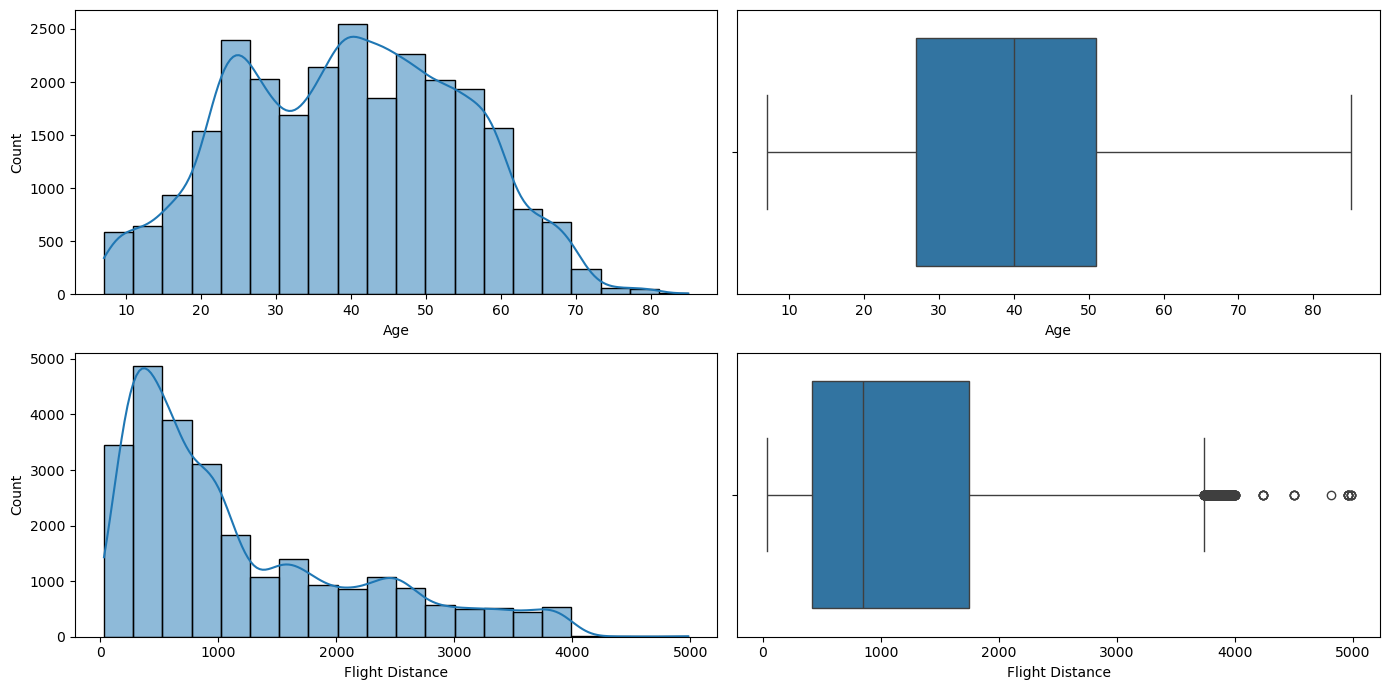

In [7]:
fig, axes = plt.subplots(nrows=len(variables_numericas), ncols=2, figsize=(14, 7))

for i in range(len(variables_numericas)):
    sns.histplot(data=X, x=variables_numericas[i], ax=axes[i, 0], bins=20, kde=True)
    sns.boxplot(data=X, x=variables_numericas[i], ax=axes[i, 1])

fig.tight_layout()

<u>Variable "Age"</u>: La variable "Age" sigue una distribución normal y no parece tener valores atípicos.  

<u>Variable "Flight Distance"</u>: Si se asume que "Flight Distance" sigue una distribución normal, los valores correspondientes a vuelos largos serían considerados outliers. Sin embargo, estos valores menos frecuentes son fundamentales dentro del contexto del problema y no deben eliminarse sin una justificación adecuada.  

Visualizamos la distribución de las variables categóricas:

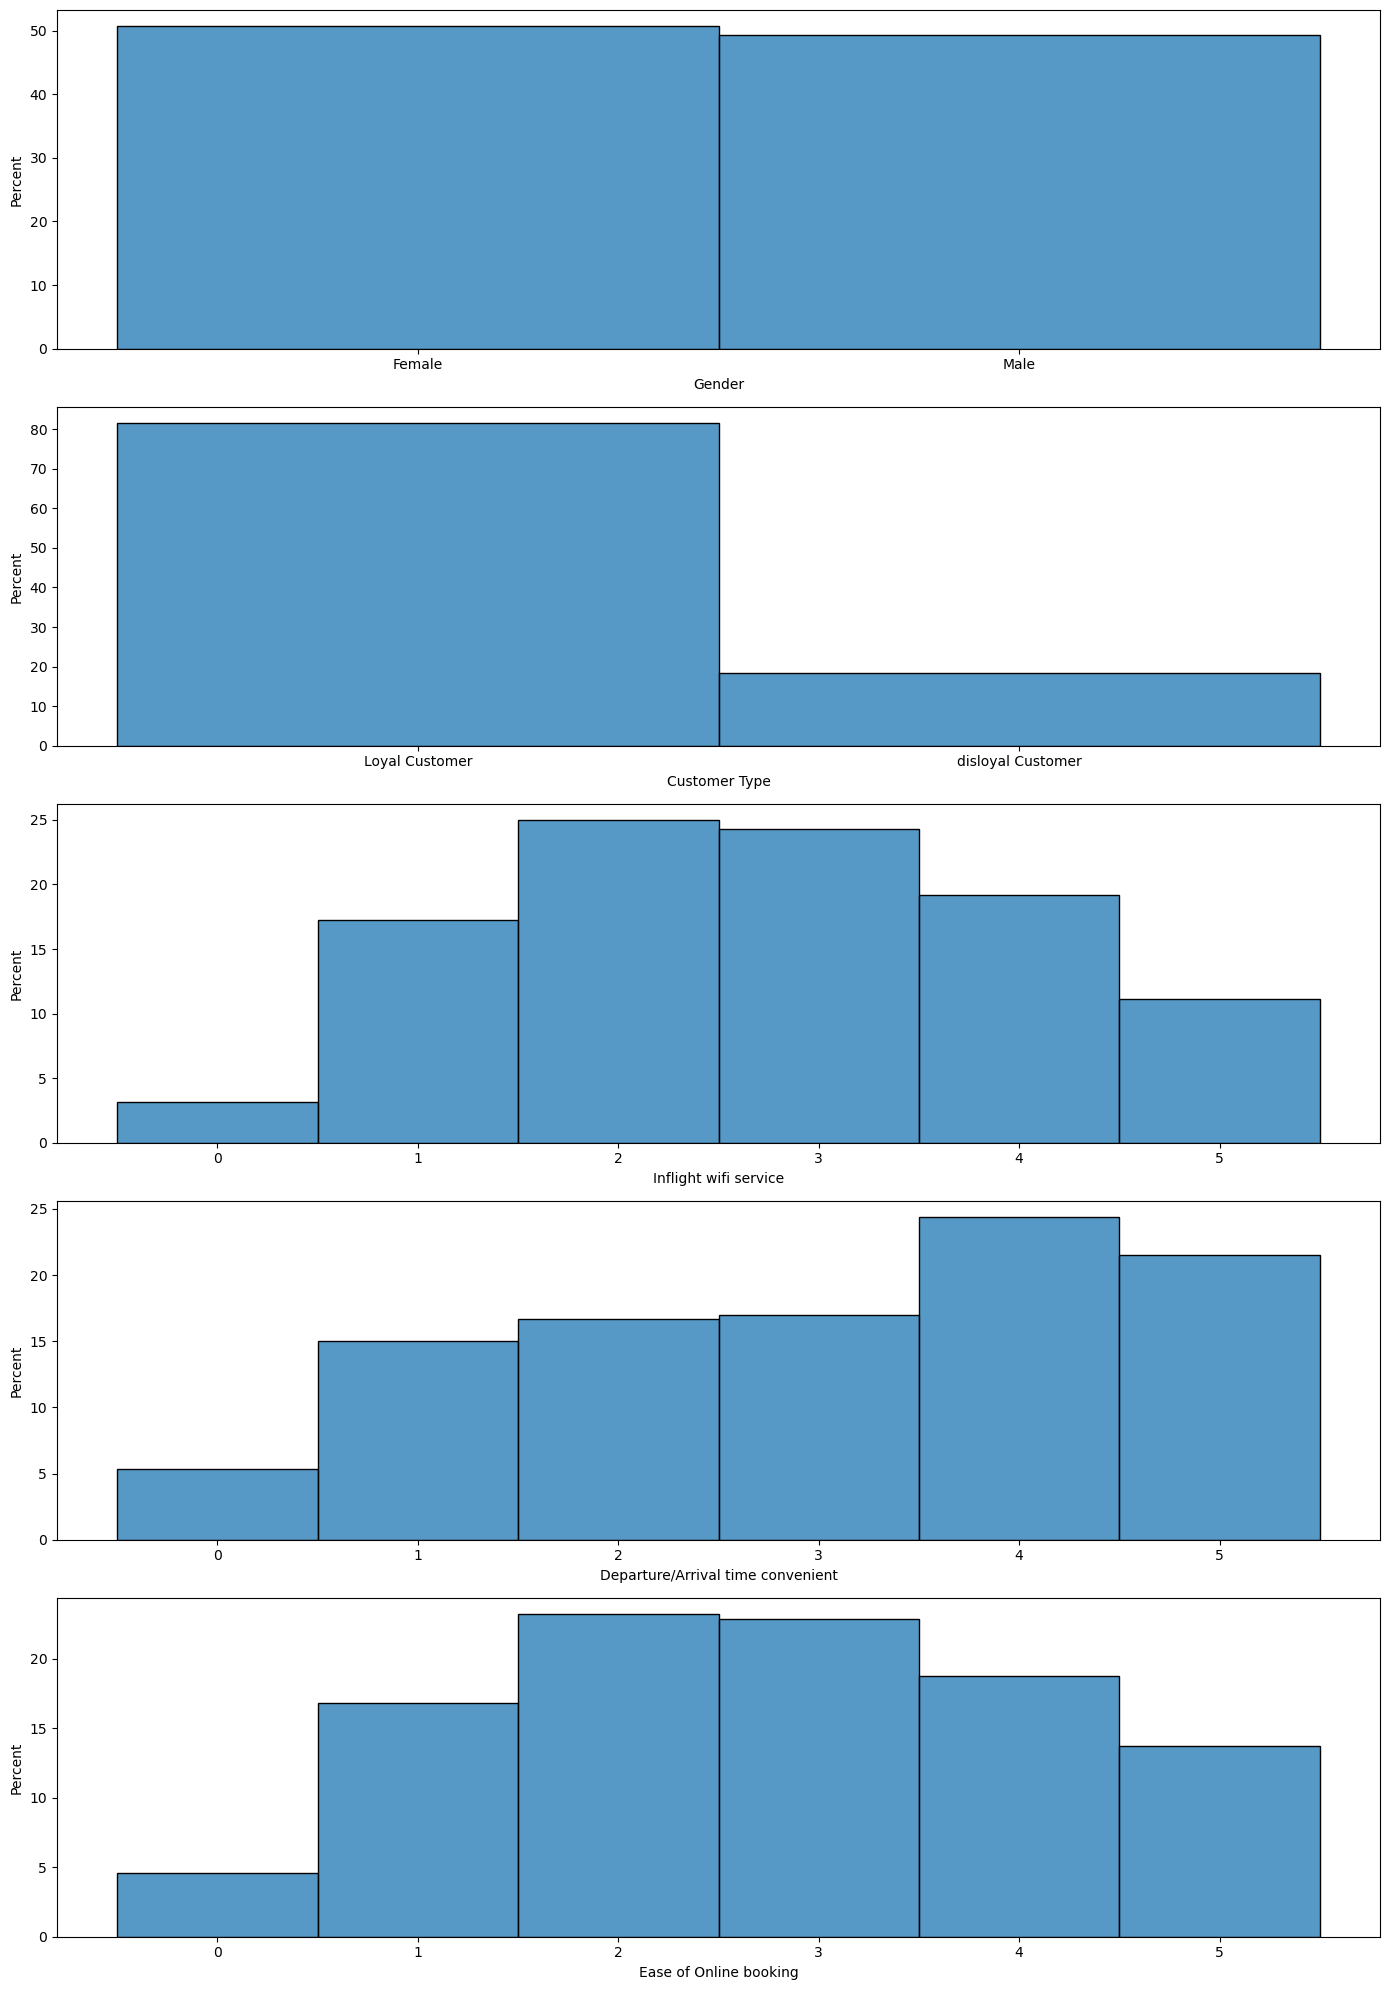

In [8]:
fig, axes = plt.subplots(nrows=len(variables_categoricas), ncols=1, figsize=(14, 20))

for i in range(len(variables_categoricas)):
    sns.histplot(data=X, x=variables_categoricas[i], stat='percent', discrete=True, ax=axes[i])

fig.tight_layout()

Visualizamos la relación entre las variables numéricas y la salida:

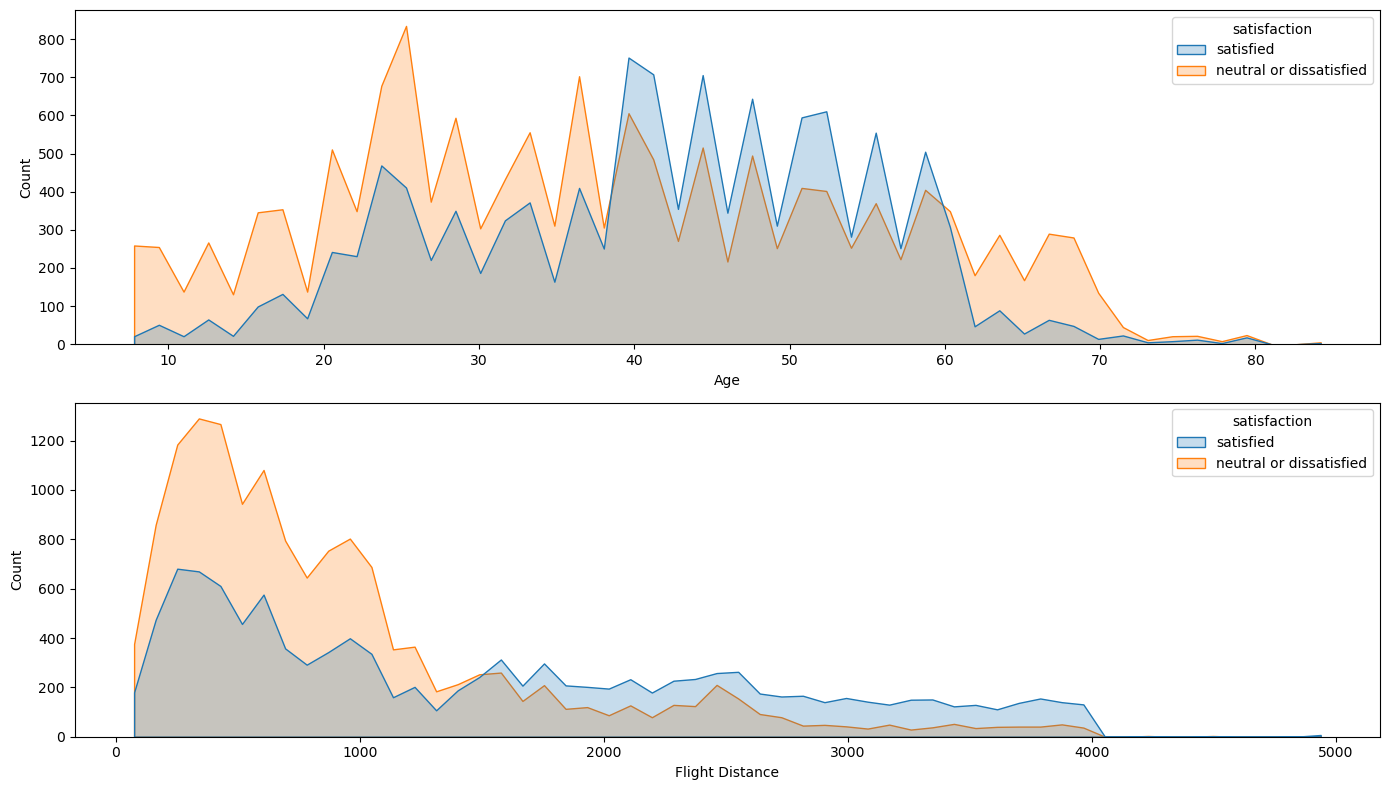

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))

sns.histplot(data=data, x=variables_numericas[0], hue=variableSalida[0], ax=axes[0], element='poly')
sns.histplot(data=data, x=variables_numericas[1], hue=variableSalida[0], ax=axes[1], element='poly')

plt.tight_layout()
plt.show()

- Personas menores de 40 años suelen estar menos satisfechos que las personas mayores.
- Los vuelos de menor longitud son los que menos clientes satisfechos tienen.


Visualizamos la relación entre las variables categóricas y la salida:

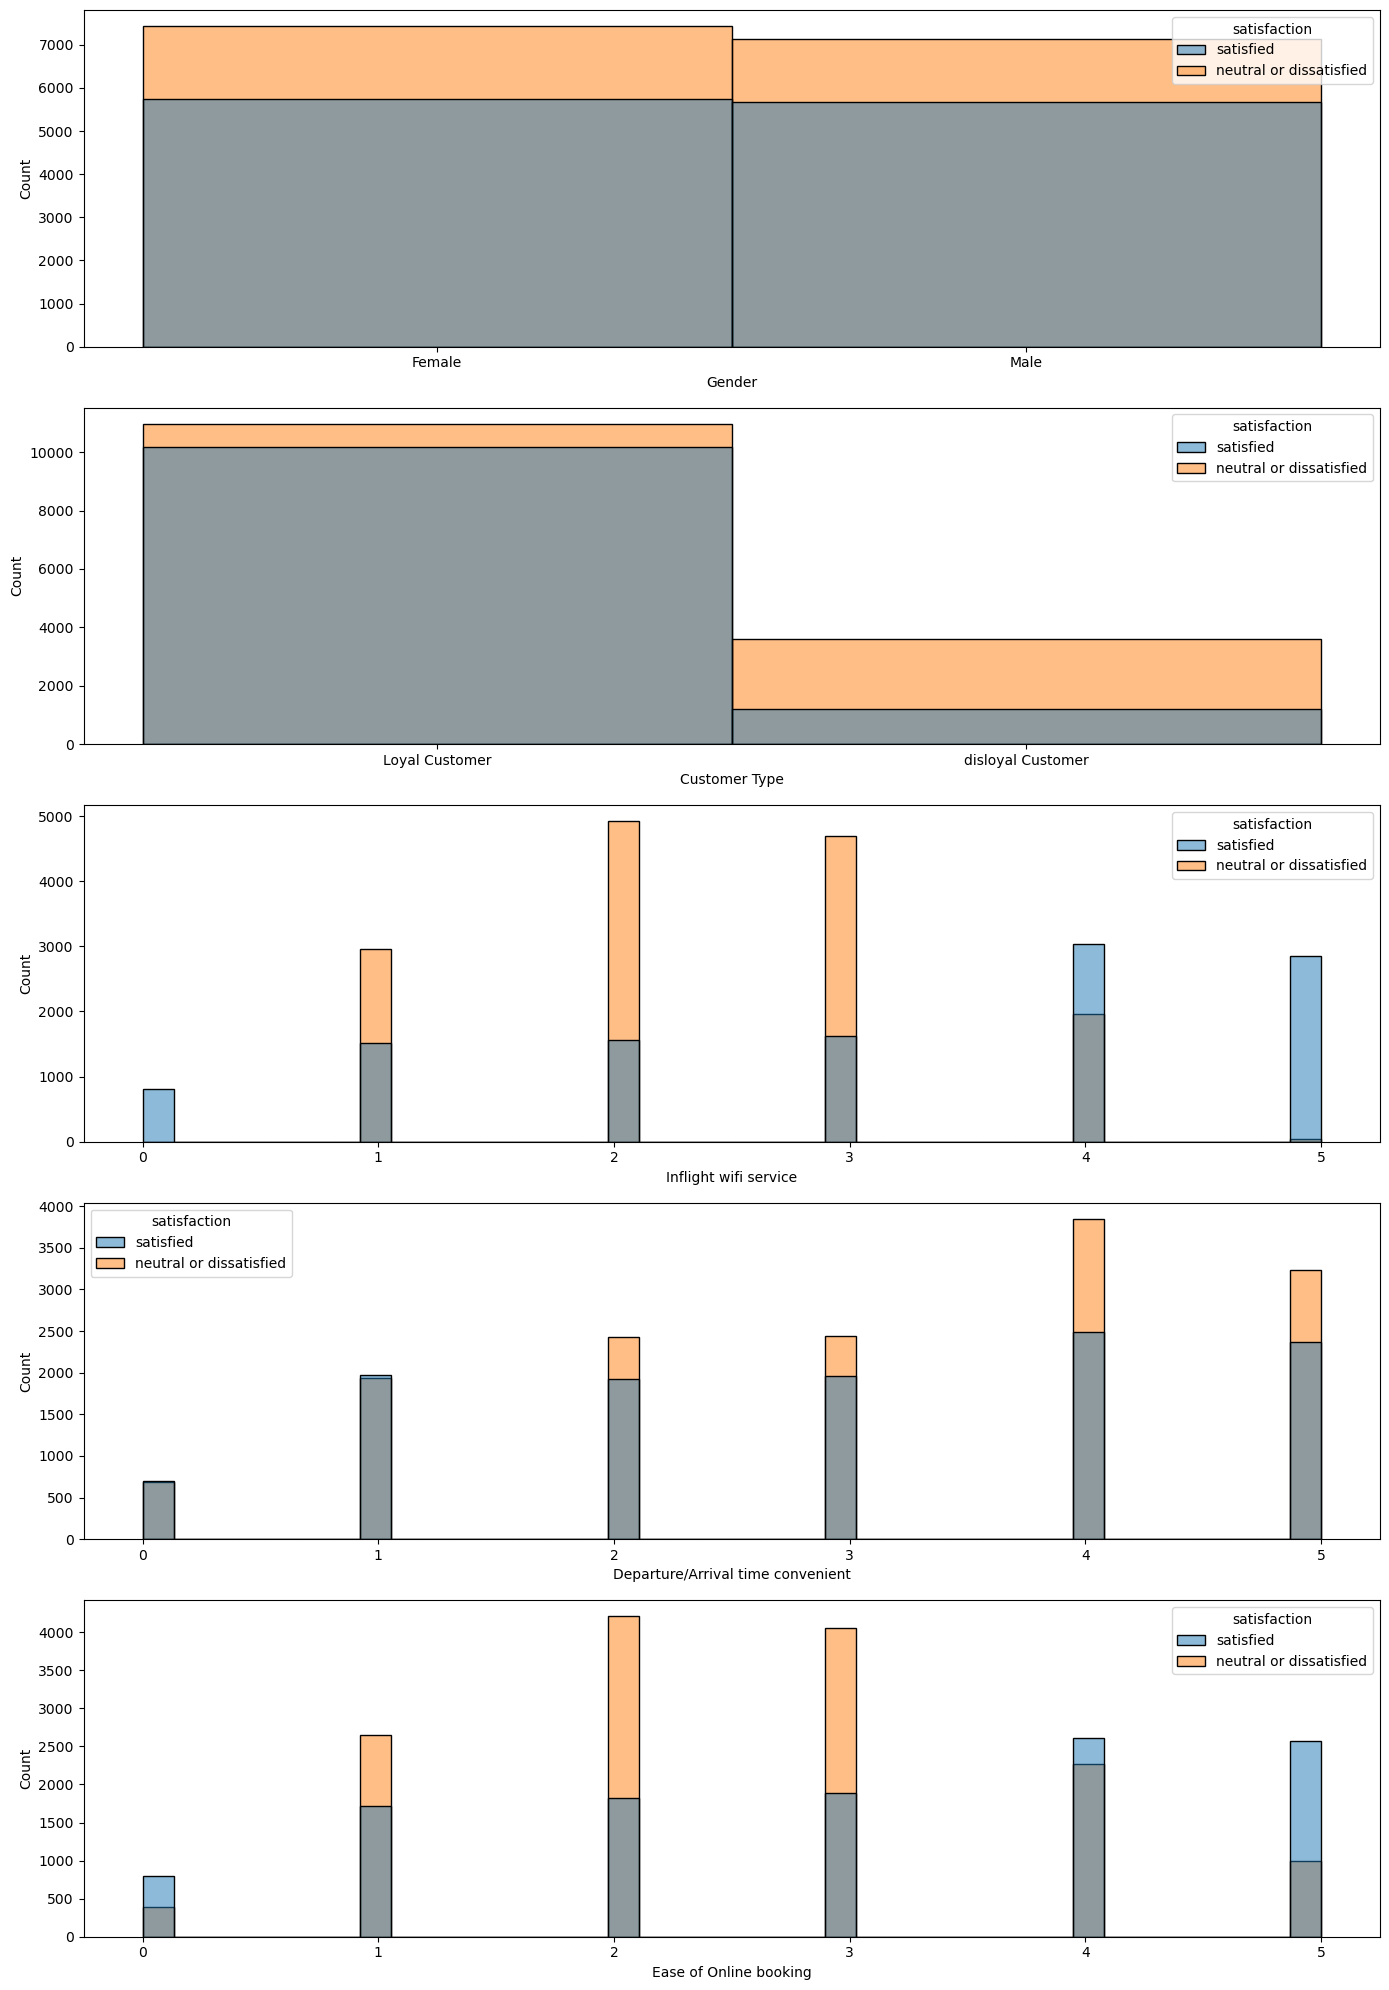

In [10]:
fig, axes = plt.subplots(nrows=len(variables_categoricas), ncols=1, figsize=(14, 20))

for i in range(len(variables_categoricas)):
    sns.histplot(data=data, x=variables_categoricas[i], hue=variableSalida[0], ax=axes[i])

plt.tight_layout()
plt.show()

Encontramos los siguientes casos que hacen que el cliente no esté satisfecho con el vuelo:

- Mala calidad del Wifi en el vuelo
- Salida o llegada tardía o convenientes en ellas
- Dificultada a la hora de reservar los billetes online

Visualizamos la relación entre Age y Flight Distante:

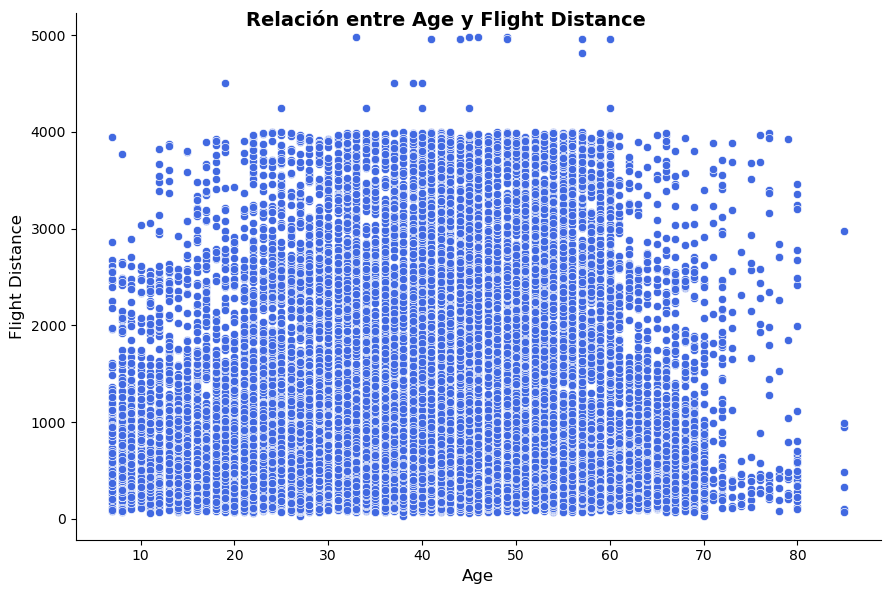

In [11]:
g1 = sns.relplot(
    x=X['Age'].values.ravel(), 
    y=X['Flight Distance'].values.ravel(),
    kind="scatter", 
    aspect=1.5, 
    height=6,
    color="royalblue" 
)

g1.fig.suptitle("Relación entre Age y Flight Distance", fontsize=14, fontweight="bold")
g1.set_axis_labels("Age", "Flight Distance", fontsize=12)
g1.ax.tick_params(labelsize=10)

plt.show()

No hay una relación entre las dos variables aparentemente.

### Transformación de variables: categórica a numérica:

En nuestro problema tenemos algunas variables categóricas. Estas deben ser convertidas a numéricas, ya que más adelante, cuando necesitemos aplicar un modelo de aprendizaje automático éstas nos darán problemas.

Las variables categóricas a transformar son las siguientes:
- Gender
- Customer Type

Primero analizaremos el número de valores únicos de cada una de las variables:

In [12]:
X["Gender"].value_counts()

Gender
Female    13172
Male      12804
Name: count, dtype: int64

In [13]:
X["Customer Type"].value_counts()

Customer Type
Loyal Customer       21177
disloyal Customer     4799
Name: count, dtype: int64

En ambos casos solo tenemos dos valores posibles. Por mantener la interpretabilidad de las variables, se empezará probando la codificación One Hot Encoding.

In [14]:
ohe_encoder = ce.OneHotEncoder(cols=['Gender', 'Customer Type'])
X_transformed = ohe_encoder.fit_transform(X)
X_transformed.head()

,Gender_1,Gender_2,Customer Type_1,Customer Type_2,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking
id,,,,,,,,,
19556,1,0,1,0,52,160,5,4,3
90035,1,0,1,0,36,2863,1,1,3
12360,0,1,0,1,20,192,2,0,2
77959,0,1,1,0,44,3377,0,0,0
36875,1,0,1,0,49,1182,2,3,4


A parte de las variables "Gender" o "Customer Type", tenemos algunas variables como "Inflight wifi service" o "Departure / Arrival time convenient" ya codificadas ordinalmente por el creador del dataset.

Esto tiene mucho sentido, ya que son variables que mantienen un orden en ellas. Por ejemplo en "Inflight wifi service":

- 0 → Wifi muy malo
- 1 → Wifi malo
- 2 → Wifi regular
- 3 → Wifi bueno
- 4 → Wifi muy bueno


### Normalización de los datos:

Para que no haya variables con más importancia que otras, es muy importante normalizar los datos. Dependiendo de la distribución de las variables, aplicaremos una normalización Z-score o basada en el máximo y el mínimo (min-max):

__Normalización Z-score:__

- Age
- Flight Distance

__Normalización min-max:__

- Gender_1
- Gender_2
- Customer Type_1
- Customer Type_2
- Inflight wifi service
- Departure/Arrival time convenient
- Ease of Online booking

En el caso de la normalización min-max, el nuevo rango de las variables será [-1, 1], para que tenga un rango similiar a los datos normalizados con Z-score.

### Pipeline de preprocesamiento:

Para aplicar el preprocesamiento de manera más sencilla y evitar errores que nos lleven a cometer Data Leakage, crearemos una Pipeline que se encargue de aplicar este preprocesamiento de manera adecuada.

Primero creamos la Pipeline que preprocesará las variables categóricas aún NO codificadas:

In [15]:
categorical_preprocessor = Pipeline(steps=[
    ('ohe_encoder', ce.OneHotEncoder()),
    ('scaler', MinMaxScaler(feature_range=(-1, 1)))
])

Creamos un ColumnTransformer que se encargue de transformar todas las variables:

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        # Codificamos y normalizamos las variables categóricas NO codificadas
        ('categorical_preprocessor', categorical_preprocessor, ["Gender", "Customer Type"]), 
        # Normalizamos las variables categóricas codificadas ordinalmente
        ('min_max_scaler', MinMaxScaler(feature_range=(-1, 1)), ["Inflight wifi service",
                                                       "Departure/Arrival time convenient", 
                                                       "Ease of Online booking"]),
        # Normalizamos las variables numéricas
        ('standard_scaler', StandardScaler(), ["Age", "Flight Distance"])
    ]
)

In [17]:
X = preprocessor.fit_transform(X)

# Visualizamos los datos transformados
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8
0,1.0,-1.0,1.0,-1.0,1.0,0.6,0.2,0.817887,-1.035171
1,1.0,-1.0,1.0,-1.0,-0.6,-0.6,0.2,-0.239238,1.671443
2,-1.0,1.0,-1.0,1.0,-0.2,-1.0,-0.2,-1.296363,-1.003128
3,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,0.289325,2.186131
4,1.0,-1.0,1.0,-1.0,-0.2,0.2,0.6,0.619676,-0.011804


### Pipeline con preprocesamiento y KNN:

In [ ]:
modelo = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', neighbors.KNeighborsRegressor())
])

